In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy.stats import kstest, f_oneway

In [2]:
RESULTS = 'results/'
PLOTS = f'{RESULTS}plots/'
REPORTS = f'{RESULTS}reports'
BFE = f'{RESULTS}best_fitness_execution/'

In [3]:
parametricos = pd.read_csv(f"{BFE}best_fit_per_config_parametric.csv")
resultados = pd.read_csv(f"{RESULTS}resultados.csv")

In [4]:
plt.style.use('ggplot')

In [5]:
def normality_test(sample): 
        standarized_sample = (sample - np.mean(sample)) / np.std(sample, ddof=1)
        return kstest(standarized_sample, "norm", alternative='two-sided').pvalue

def anova_test(samples):
        return f_oneway(*samples).pvalue

In [6]:
def print_hist_plots(df, plot_name, size=(20,20)):
    fig, axs = plt.subplots(ceil(len(df.columns)/2), 2, figsize=size)
    for col,ax in zip(df.columns, axs.flatten()):
        ax.hist(df[col], density=True)
        ax.set_title(col)
        xlim = ax.get_xlim()
        
        # kernel density estimate
        df[col].plot.density(color='k', alpha=0.5, ax=ax)
        
        ax.set_xlim(xlim)
        ax.legend(labels=['KDE'], frameon=False)
        ax.text(0.98, 0.9, f"p-value={normality_test(df[col]):.5f}", verticalalignment ='top', horizontalalignment ='right', transform = ax.transAxes, color ='black', fontsize = 12)
        
        ax.set_title(col, fontsize=14, pad=15)
        
    fig.savefig(f"{PLOTS}{plot_name}.png")

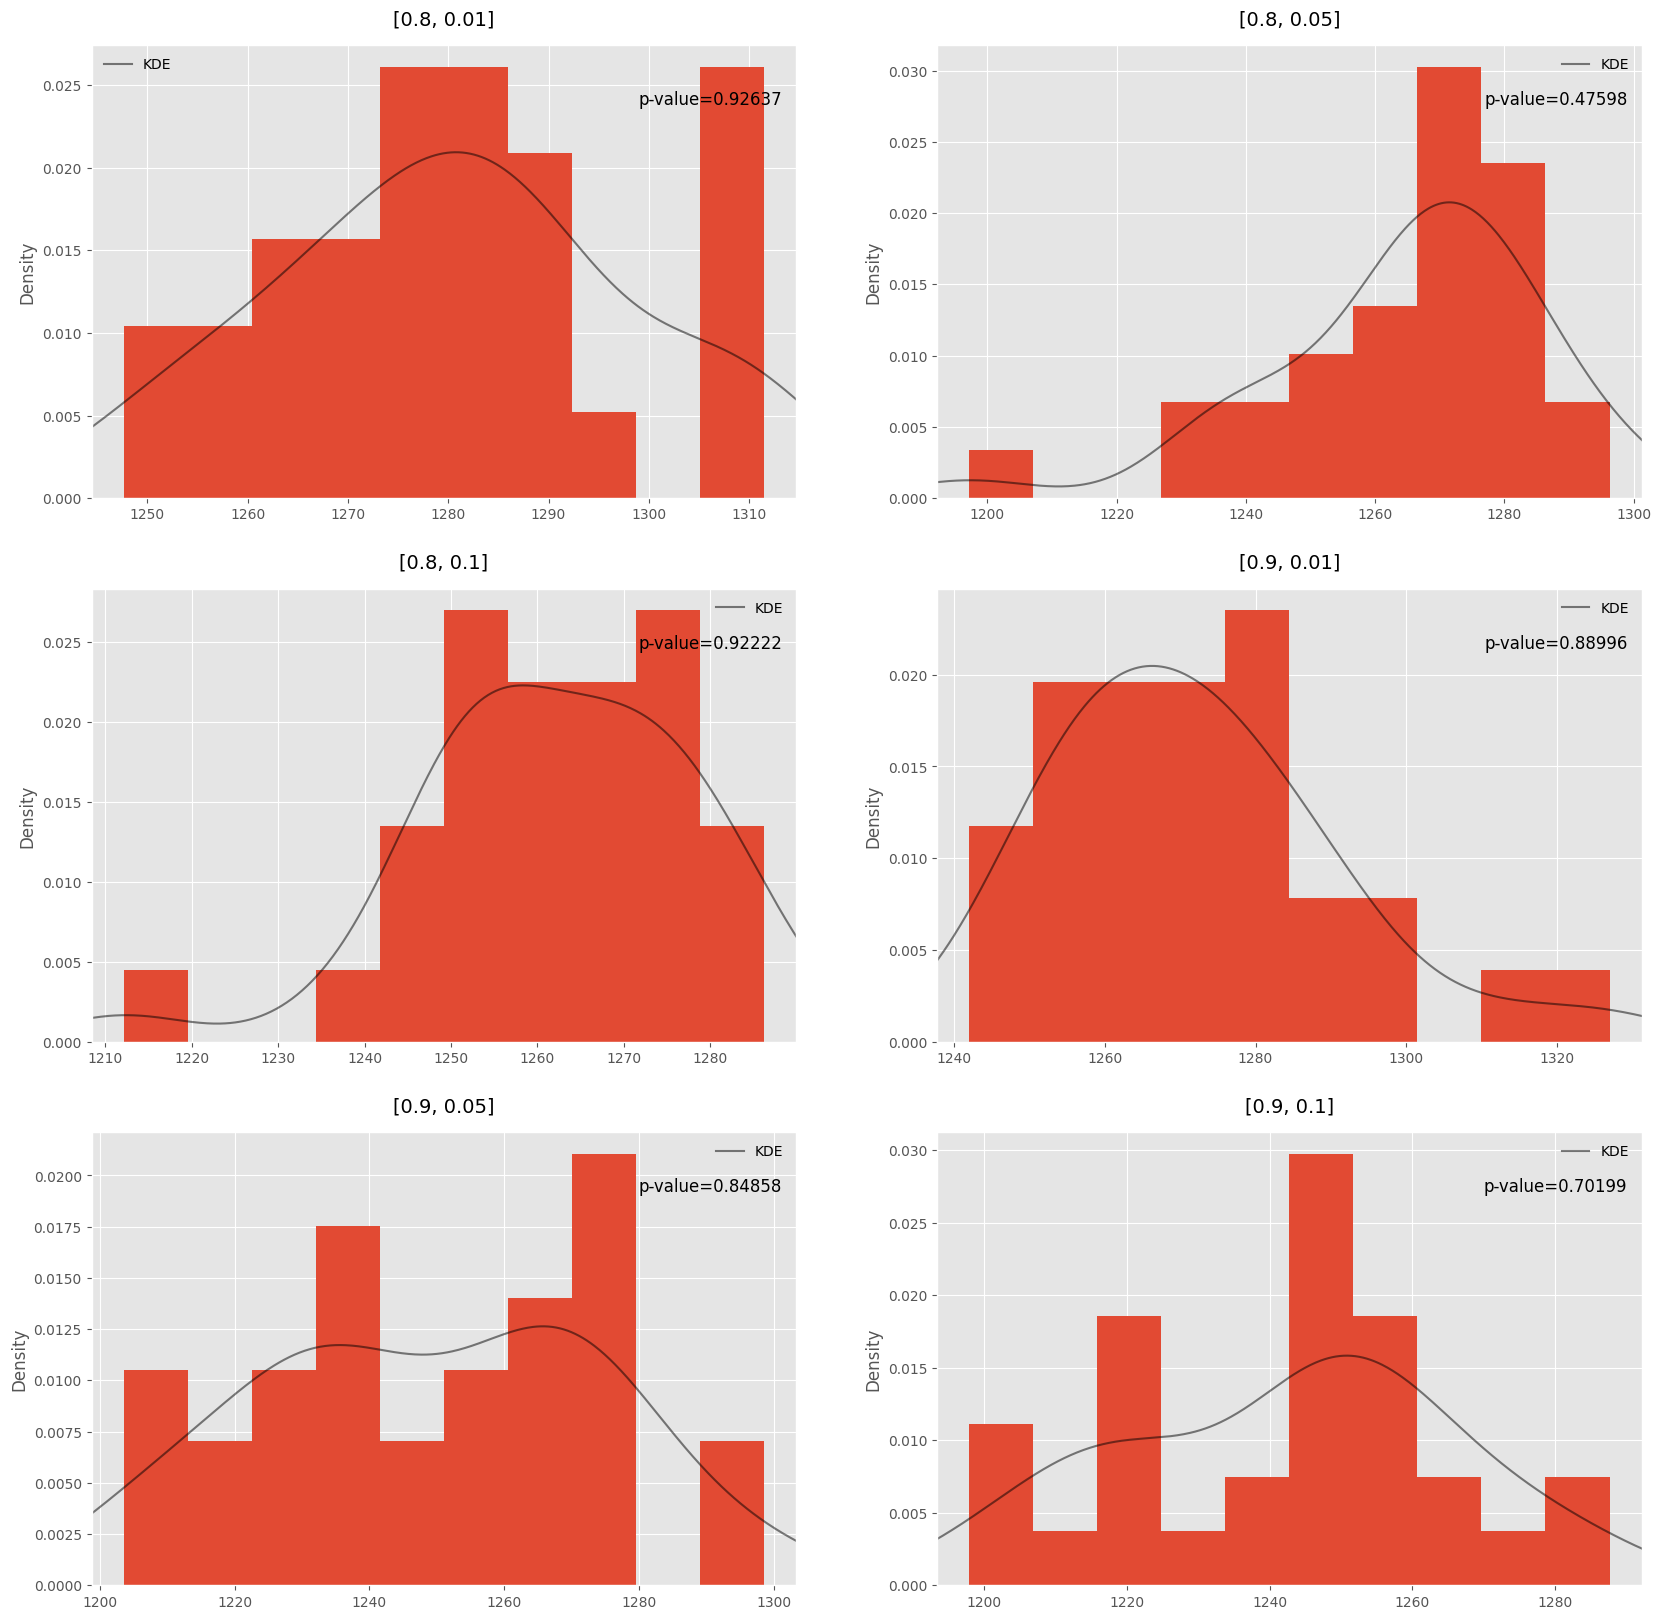

In [7]:
print_hist_plots(parametricos, "parametric")

In [8]:
f_oneway(*[parametricos[col] for col in parametricos.columns])

F_onewayResult(statistic=14.03663642461185, pvalue=1.575577368841548e-11)

The p-value turn out to be 1.5755e-11. <br>
Since the p-value is less than 0.05 hence we would reject the null hypothesis. <br>
This implies that we have sufficient proof to say that there exists a difference in the performance among four different configurations. 

In [9]:
import scikit_posthocs as ph
parametricos.head()

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
0,1285.671766,1296.231587,1257.136032,1282.188690,1270.801786,1247.136131
1,1277.800476,1266.708730,1277.859544,1293.368016,1203.522421,1222.599365
2,1283.520714,1282.181905,1257.915040,1267.736964,1268.195933,1278.843651
3,1268.604563,1296.280893,1212.099583,1276.484762,1238.116230,1276.717440
4,1266.432718,1197.161528,1278.339365,1276.006925,1253.702222,1248.549722


In [10]:
#convert dataframe into a single column
fitness_by_method = parametricos.melt(var_name='parameters', value_name='best_fitness')
fitness_by_method

,parameters,best_fitness
0,"[0.8, 0.01]",1285.671766
1,"[0.8, 0.01]",1277.800476
2,"[0.8, 0.01]",1283.520714
3,"[0.8, 0.01]",1268.604563
4,"[0.8, 0.01]",1266.432718
...,...,...
175,"[0.9, 0.1]",1218.881627
176,"[0.9, 0.1]",1227.741012
177,"[0.9, 0.1]",1206.390020
178,"[0.9, 0.1]",1256.998393


In [11]:
#tstudent posthoc
ttest_posthoc = ph.posthoc_ttest(fitness_by_method, val_col='best_fitness', group_col='parameters', p_adjust='holm')
ttest_posthoc

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
"[0.8, 0.01]",1.000000e+00,0.018151,0.000669,0.279405,0.000009,2.566644e-08
"[0.8, 0.05]",1.815146e-02,1.000000,0.603387,0.499834,0.085718,2.846815e-03
"[0.8, 0.1]",6.690714e-04,0.603387,1.000000,0.147607,0.147607,4.044384e-03
"[0.9, 0.01]",2.794054e-01,0.499834,0.147607,1.000000,0.002484,2.060808e-05
"[0.9, 0.05]",9.193886e-06,0.085718,0.147607,0.002484,1.000000,6.033868e-01
"[0.9, 0.1]",2.566644e-08,0.002847,0.004044,0.000021,0.603387,1.000000e+00


In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey2_posthoc = pairwise_tukeyhsd(endog=fitness_by_method['best_fitness'], groups=fitness_by_method['parameters'], alpha=0.05)
tukey2_posthoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
"[0.8, 0.01]","[0.8, 0.05]",-15.9054,0.0371,-31.2401,-0.5708,True
"[0.8, 0.01]","[0.8, 0.1]",-18.8052,0.0068,-34.1399,-3.4706,True
"[0.8, 0.01]","[0.9, 0.01]",-8.6888,0.578,-24.0235,6.6458,False
"[0.8, 0.01]","[0.9, 0.05]",-31.4542,0.0,-46.7888,-16.1195,True
"[0.8, 0.01]","[0.9, 0.1]",-38.022,0.0,-53.3566,-22.6873,True
"[0.8, 0.05]","[0.8, 0.1]",-2.8998,0.9942,-18.2345,12.4348,False
"[0.8, 0.05]","[0.9, 0.01]",7.2166,0.753,-8.1181,22.5512,False
"[0.8, 0.05]","[0.9, 0.05]",-15.5488,0.0448,-30.8834,-0.2141,True
"[0.8, 0.05]","[0.9, 0.1]",-22.1166,0.0007,-37.4512,-6.7819,True
"[0.8, 0.1]","[0.9, 0.01]",10.1164,0.405,-5.2183,25.451,False


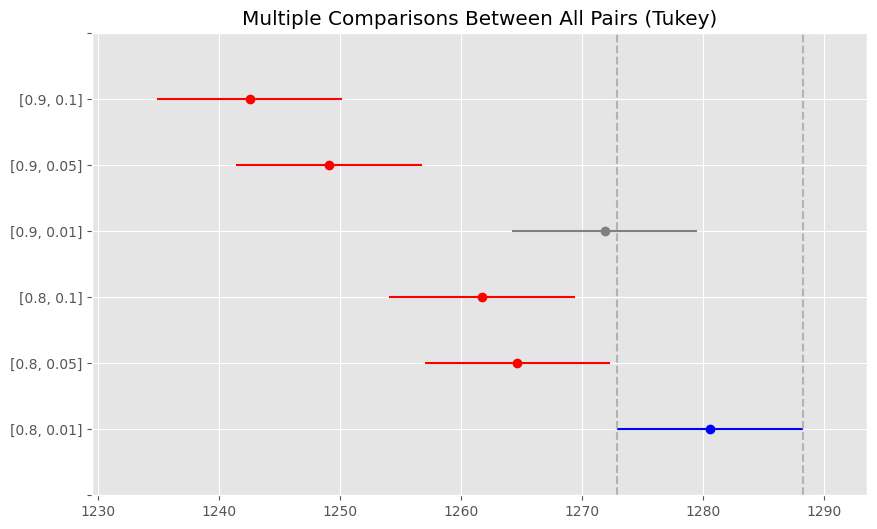

In [13]:
fig = tukey2_posthoc.plot_simultaneous(comparison_name='[0.8, 0.01]')

In [14]:
tstudent_configs = { (r,c):(ttest_posthoc.index[r],ttest_posthoc.columns[c]) for (r,c) in zip(*np.where(ttest_posthoc[ttest_posthoc < 0.05].notnull())) if r<c }
tstudent_configs

{(0, 1): ('[0.8, 0.01]', '[0.8, 0.05]'),
 (0, 2): ('[0.8, 0.01]', '[0.8, 0.1]'),
 (0, 4): ('[0.8, 0.01]', '[0.9, 0.05]'),
 (0, 5): ('[0.8, 0.01]', '[0.9, 0.1]'),
 (1, 5): ('[0.8, 0.05]', '[0.9, 0.1]'),
 (2, 5): ('[0.8, 0.1]', '[0.9, 0.1]'),
 (3, 4): ('[0.9, 0.01]', '[0.9, 0.05]'),
 (3, 5): ('[0.9, 0.01]', '[0.9, 0.1]')}

In [15]:
rs= {}
idx=0
semi_resultados = resultados[["best_historical_fitness", "avg_best_fitness", "std_fitness", "avg_time"]]
for (r,c),(c1,c2) in tstudent_configs.items():
    resta = semi_resultados[semi_resultados.index==r].values - semi_resultados[semi_resultados.index==c].values
    reshaped = list(resta.reshape(-1))
    configs = [c1, c2]
    configs.extend(reshaped)
    rs[idx] = configs
    idx+=1

config1 - config2

In [16]:
resultados_significativos = pd.DataFrame.from_dict(data=rs, columns=["Config1", "Config2", *semi_resultados.columns], orient='index')
resultados_significativos

,Config1,Config2,best_historical_fitness,avg_best_fitness,std_fitness,avg_time
0,"[0.8, 0.01]","[0.8, 0.05]",50.454325,15.905402,-3.386813,-4.313221
1,"[0.8, 0.01]","[0.8, 0.1]",35.516270,18.805210,1.499448,-10.697836
2,"[0.8, 0.01]","[0.9, 0.05]",44.093433,31.454173,-7.805998,-35.498707
3,"[0.8, 0.01]","[0.9, 0.1]",49.678909,38.021956,-5.762953,-37.318566
4,"[0.8, 0.05]","[0.9, 0.1]",-0.775417,22.116554,-2.376140,-33.005345
5,"[0.8, 0.1]","[0.9, 0.1]",14.162639,19.216745,-7.262401,-26.620731
6,"[0.9, 0.01]","[0.9, 0.05]",38.416111,22.765354,-6.392886,-1.890985
7,"[0.9, 0.01]","[0.9, 0.1]",44.001587,29.333137,-4.349841,-3.710844


In [17]:
gl = resultados_significativos.groupby("Config1")
gr = resultados_significativos.groupby("Config2")
app = lambda df, g: len(df.get_group(g)) if g in df.groups.keys() else 0
win_left = lambda df, g: len(df.get_group(g)[df.get_group(g)["avg_best_fitness"] > 0]) if g in df.groups.keys() else 0
win_right = lambda df, g: len(df.get_group(g)[df.get_group(g)["avg_best_fitness"] < 0]) if g in df.groups.keys() else 0

ranking = []
for g in gl.groups.keys():
    appearances = app(gl, g) + app(gr, g)
    wins = win_left(gl, g) + win_right(gr, g)
    ranked = wins/appearances
    ranking.append([g, appearances, wins, ranked])
ranking = pd.DataFrame(data=ranking, columns=["Config", "appearances", "wins", "ranked"])
ranking.sort_values(by="ranked", inplace=True, ascending=False)
ranking

,Config,appearances,wins,ranked
0,"[0.8, 0.01]",4,4,1.0
3,"[0.9, 0.01]",2,2,1.0
1,"[0.8, 0.05]",2,1,0.5
2,"[0.8, 0.1]",2,1,0.5


In [18]:
resultados

,CXPB,MUTPB,best_historical_fitness,avg_best_fitness,std_fitness,avg_time,p-value
0,0.8,0.01,1247.615853,1280.579688,17.192971,420.956239,0.926373
1,0.8,0.05,1197.161528,1264.674286,20.579784,425.269461,0.475978
2,0.8,0.10,1212.099583,1261.774478,15.693523,431.654075,0.922218
3,0.9,0.01,1241.938532,1271.890869,18.606082,454.563961,0.889964
4,0.9,0.05,1203.522421,1249.125515,24.998969,456.454946,0.848576
5,0.9,0.10,1197.936944,1242.557732,22.955924,458.274806,0.701994


Como puede observarse en los resultados, tanto el mejor fitness histórico como promedio es mínimo para la combinación de [0.9, 0.10]. Existe evidencia para decir que esta combinacón es mejor que las demás con un nivel de confidencia del 0.05 excepto por [0.9, 0.05]. Aún así, se decide tomar [0.9, 0.10] dado que la diferencia en tiempo no es significativa y tuvo mejores resultados en los demás atributos.

In [19]:
#tstudent posthoc en tests informales

informales = pd.read_csv(f"{BFE}best_fit_per_config_informal.csv")
informales.head()


,[2],[3]
0,1295.056369,1332.464226
1,1314.083492,1307.888571
2,1321.953571,1319.988810
3,1280.405496,1286.903373
4,1315.279841,1268.527599


In [20]:
best_fitness_informal = pd.read_csv(f"{RESULTS}informal.csv")
best_fitness_informal

,tournament_size,best_historical_fitness,avg_best_fitness,std_fitness,avg_time,p-value
0,2,1277.845000,1287.592392,18.530151,478.450672,0.872560
1,3,1337.026012,1295.067064,21.619478,491.637074,0.986265


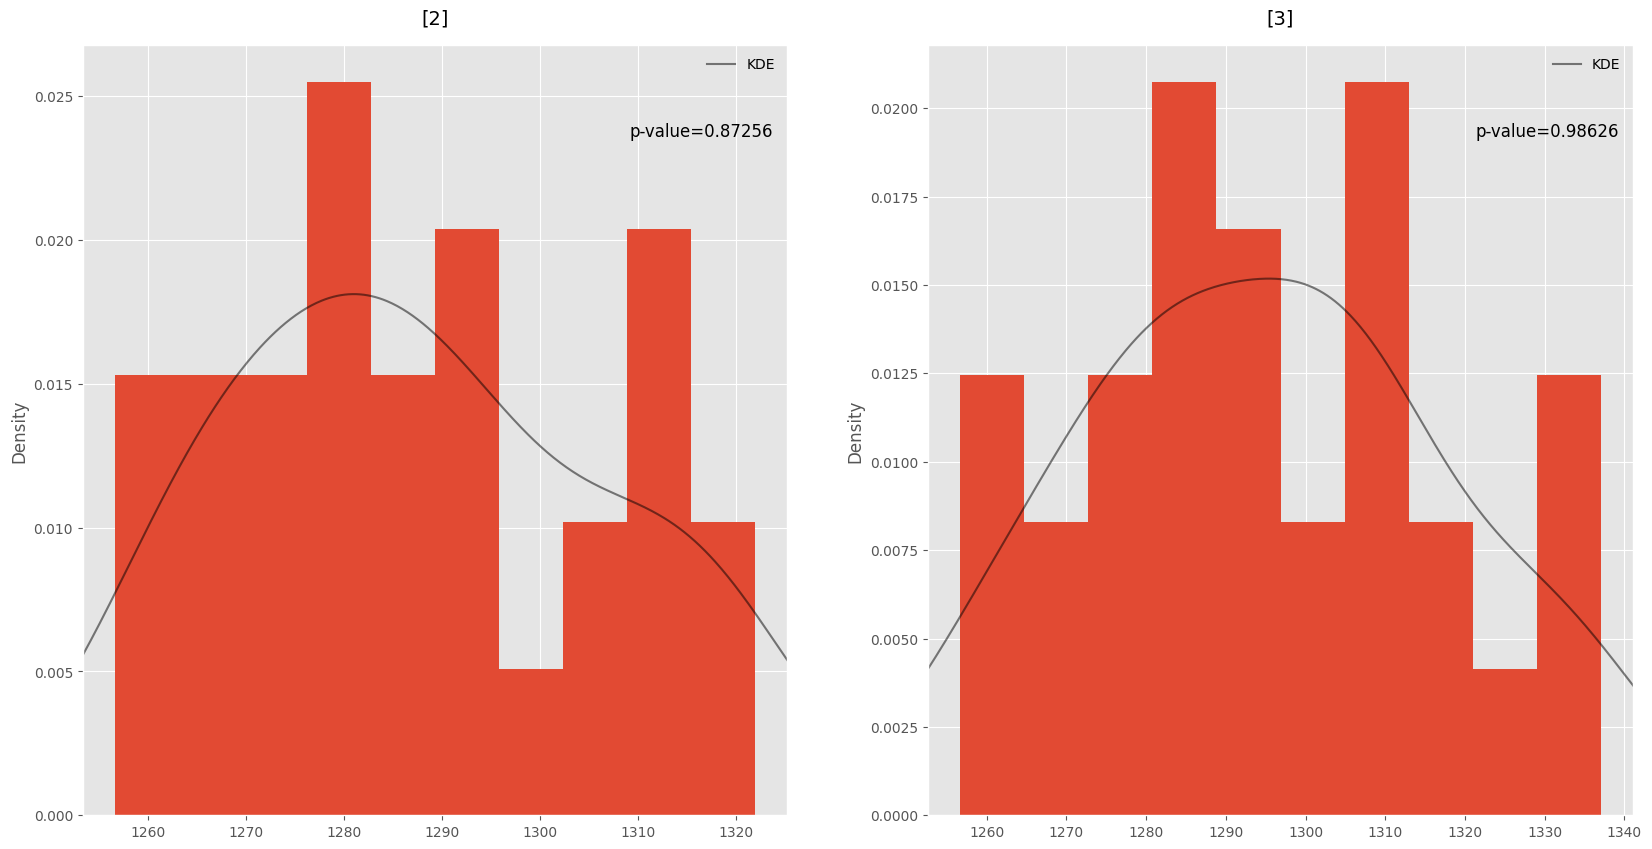

In [21]:
#Test de normalidad
print_hist_plots(informales, "informal", size=(20,10))

De aquí resulta que no se rechaza la hipótesis de normalidad.

In [22]:
# normality test
f_oneway(*[informales[col] for col in informales.columns])

F_onewayResult(statistic=1.9984146097807995, pvalue=0.16280886774821413)

Dados estos resultados, nuevamente se puede afirmar que existe un grupo dominante, por lo que se procederá a realizar tests paramétricos.

Aca es al reves, como el p-value no es menor a 0.05 entonces no se puede rechazar la $H_{0}$ y entonces no hay evidencia estadisticamente significativa para decir que hay una diferencia entre la media de uno y otro.

Entonces el analisis termina aca (me parece)

In [23]:
#add column from parametric
informales["best"] = parametricos["[0.9, 0.1]"]
informales

,[2],[3],best
0,1295.056369,1332.464226,1247.136131
1,1314.083492,1307.888571,1222.599365
2,1321.953571,1319.988810,1278.843651
3,1280.405496,1286.903373,1276.717440
4,1315.279841,1268.527599,1248.549722
5,1293.773413,1301.607123,1249.432738
6,1277.621806,1256.683413,1287.581607
7,1262.963056,1272.258710,1197.936944
8,1320.792480,1273.519583,1243.948294
9,1304.860794,1304.547143,1269.324603


In [24]:
#convert dataframe into a single column
fitness_by_method = informales.melt(var_name='parameters', value_name='best_fitness')
fitness_by_method

,parameters,best_fitness
0,[2],1295.056369
1,[2],1314.083492
2,[2],1321.953571
3,[2],1280.405496
4,[2],1315.279841
...,...,...
85,best,1218.881627
86,best,1227.741012
87,best,1206.390020
88,best,1256.998393


In [25]:
posthoc = ph.posthoc_ttest(fitness_by_method, val_col='best_fitness', group_col='parameters', p_adjust='holm')
posthoc

,[2],[3],best
[2],1.000000e+00,1.628089e-01,5.234705e-11
[3],1.628089e-01,1.000000e+00,4.505137e-12
best,5.234705e-11,4.505137e-12,1.000000e+00


De estos resultados se observa una no tan clara diferencia entre distintos parámetros para la selección por torneos. Sin embargo, la superioridad de la selección elitista es percibida como considerablemente mejor, por lo que se decide conservar este parámetro para la etapa posterior. 

In [26]:
#comparison

comparison = pd.read_csv(f"{BFE}best_fit_per_config_comparison.csv")
comparison

,EA-fox.jpg,local_search-fox.jpg,gaussian-fox.jpg,EA-monalisa_sqr.jpg,local_search-monalisa_sqr.jpg,gaussian-monalisa_sqr.jpg,EA-old_man.jpeg,local_search-old_man.jpeg,gaussian-old_man.jpeg
0,206.205779,178.727454,217.944707,128.088327,170.901686,121.684703,620.110249,592.374942,561.641796
1,204.505092,213.027538,251.575729,141.387280,164.205103,126.966647,625.799156,557.003547,581.014400
2,202.432027,180.842462,204.394925,129.635065,166.876867,116.537048,601.603493,570.560133,620.294347
3,207.050988,188.781173,198.866147,135.253307,169.887532,112.575717,608.201813,602.707431,646.899591
4,199.235377,187.041926,244.780586,131.043559,165.759606,139.946466,619.988702,587.620631,632.211982
5,207.024188,202.299414,240.315662,130.073081,164.030329,165.024709,605.358702,587.512551,657.662889
6,207.497169,181.440000,221.366499,129.902209,150.650168,120.962280,599.273529,563.105707,591.968987
7,209.000921,188.761089,202.864606,139.012578,167.950523,122.600698,595.260613,588.225476,591.381413
8,204.717755,184.359866,230.889229,134.993036,163.133178,136.124419,617.754027,595.413351,590.848676
9,212.707052,181.183903,237.602697,140.933753,181.578553,117.705149,612.137378,583.127956,633.500489


In [27]:
instancia1, instancia2, instancia3 = (comparison.iloc[0:30,i*3:i*3+3] for i in range(3))

In [28]:
#do anderson darling test
from scipy.stats import anderson
for idx, instancia in enumerate([instancia1, instancia2, instancia3]):
    print(f"<---Instancia {idx}--->")
    for col in instancia.columns:
        print(col)
        print(anderson(instancia[col], dist='norm'))

<---Instancia 0--->
EA-fox.jpg
AndersonResult(statistic=0.22557731396100067, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
local_search-fox.jpg
AndersonResult(statistic=0.5077355446957696, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
gaussian-fox.jpg
AndersonResult(statistic=0.16228289975953913, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
<---Instancia 1--->
EA-monalisa_sqr.jpg
AndersonResult(statistic=1.2436302827632026, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
local_search-monalisa_sqr.jpg
AndersonResult(statistic=0.3641690367267749, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
gaussian-monalisa_sqr.jpg
AndersonResult(sta

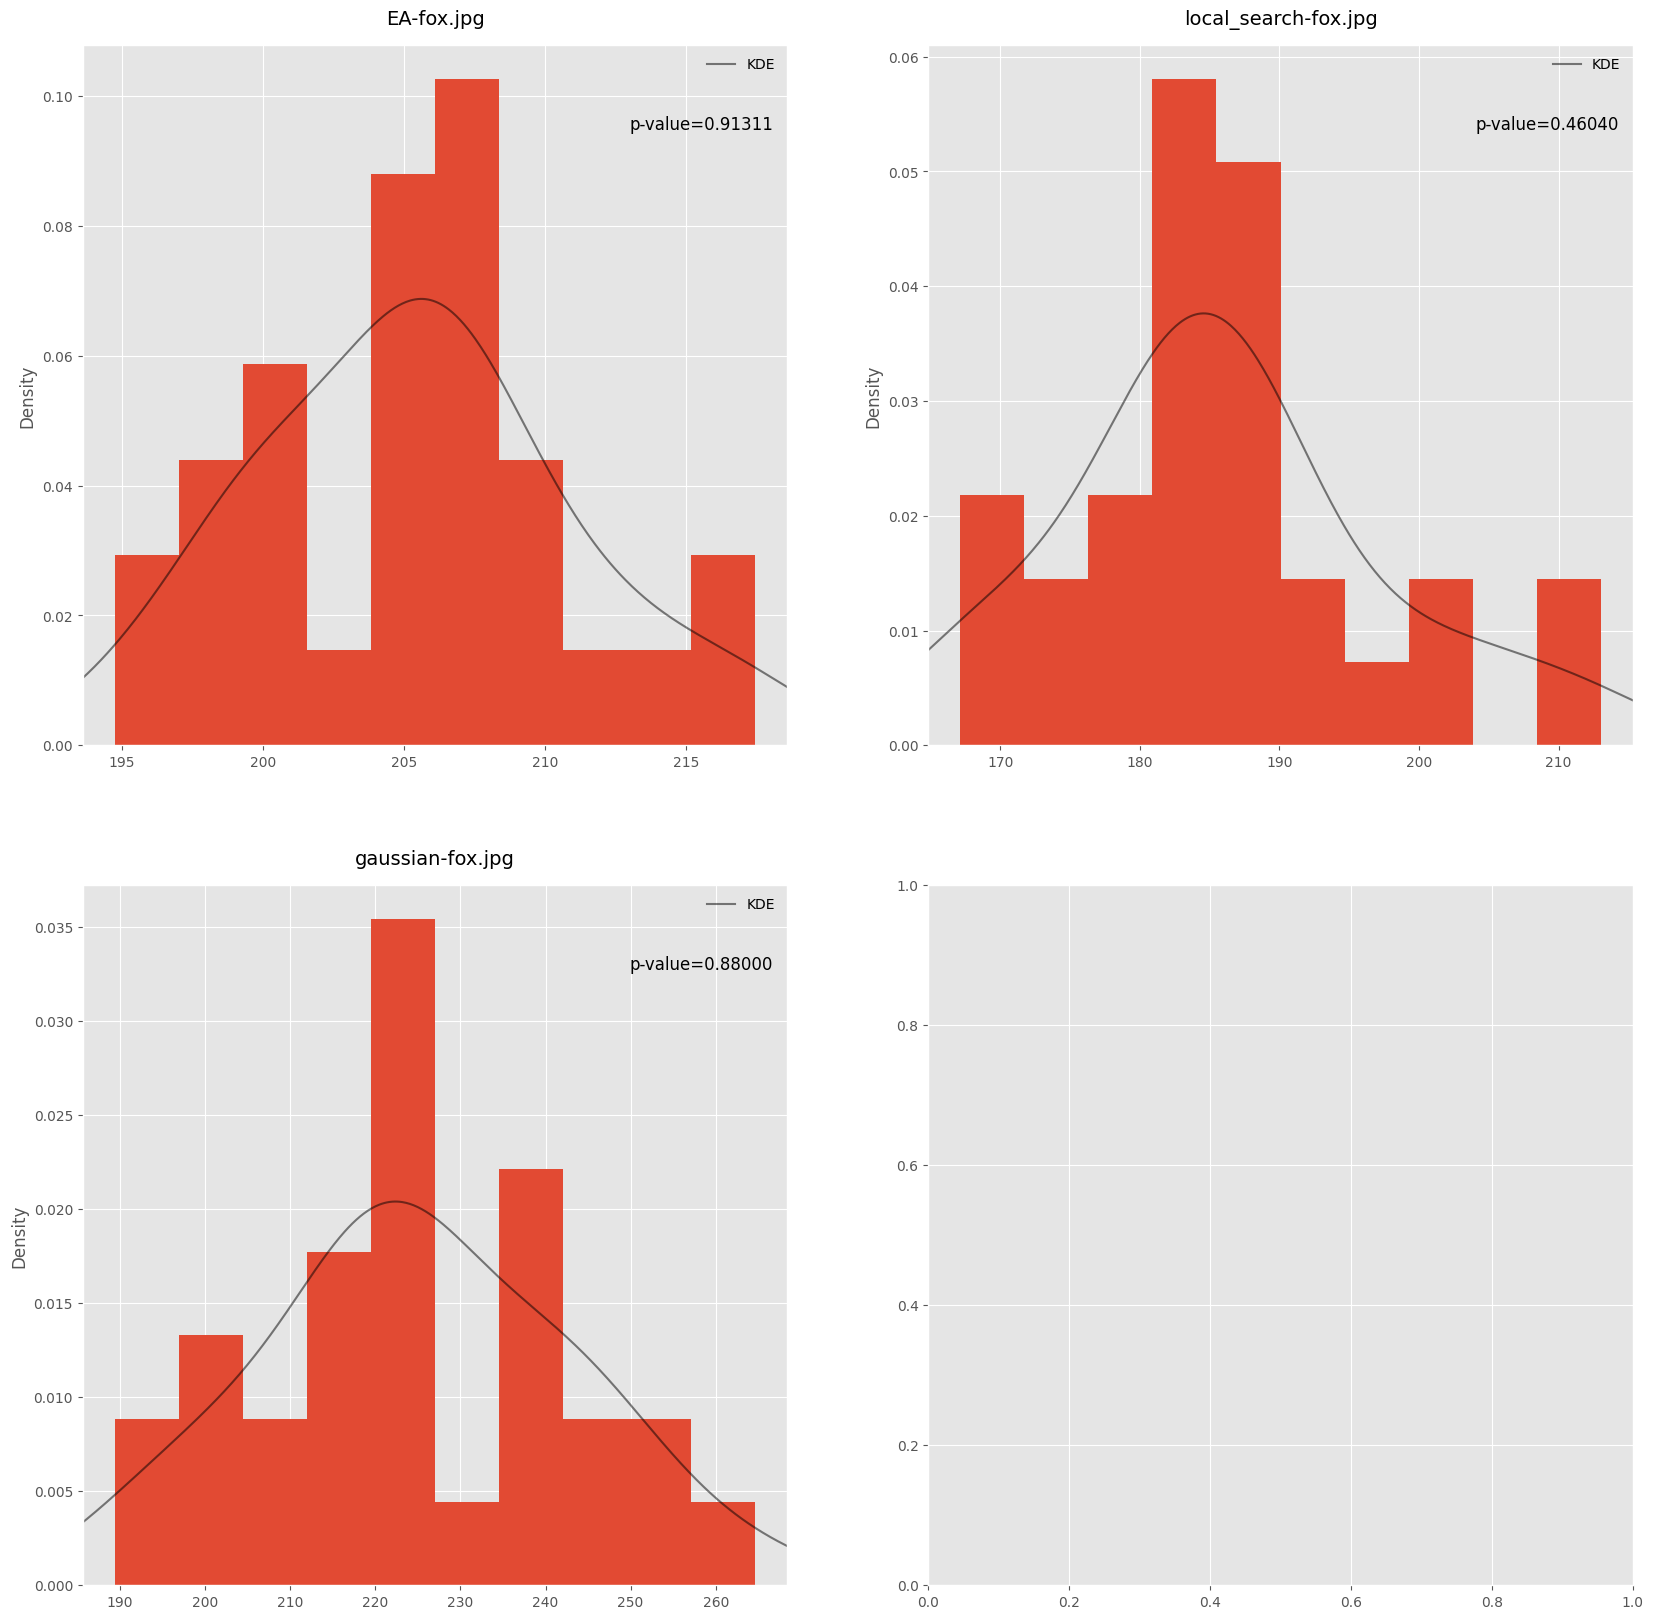

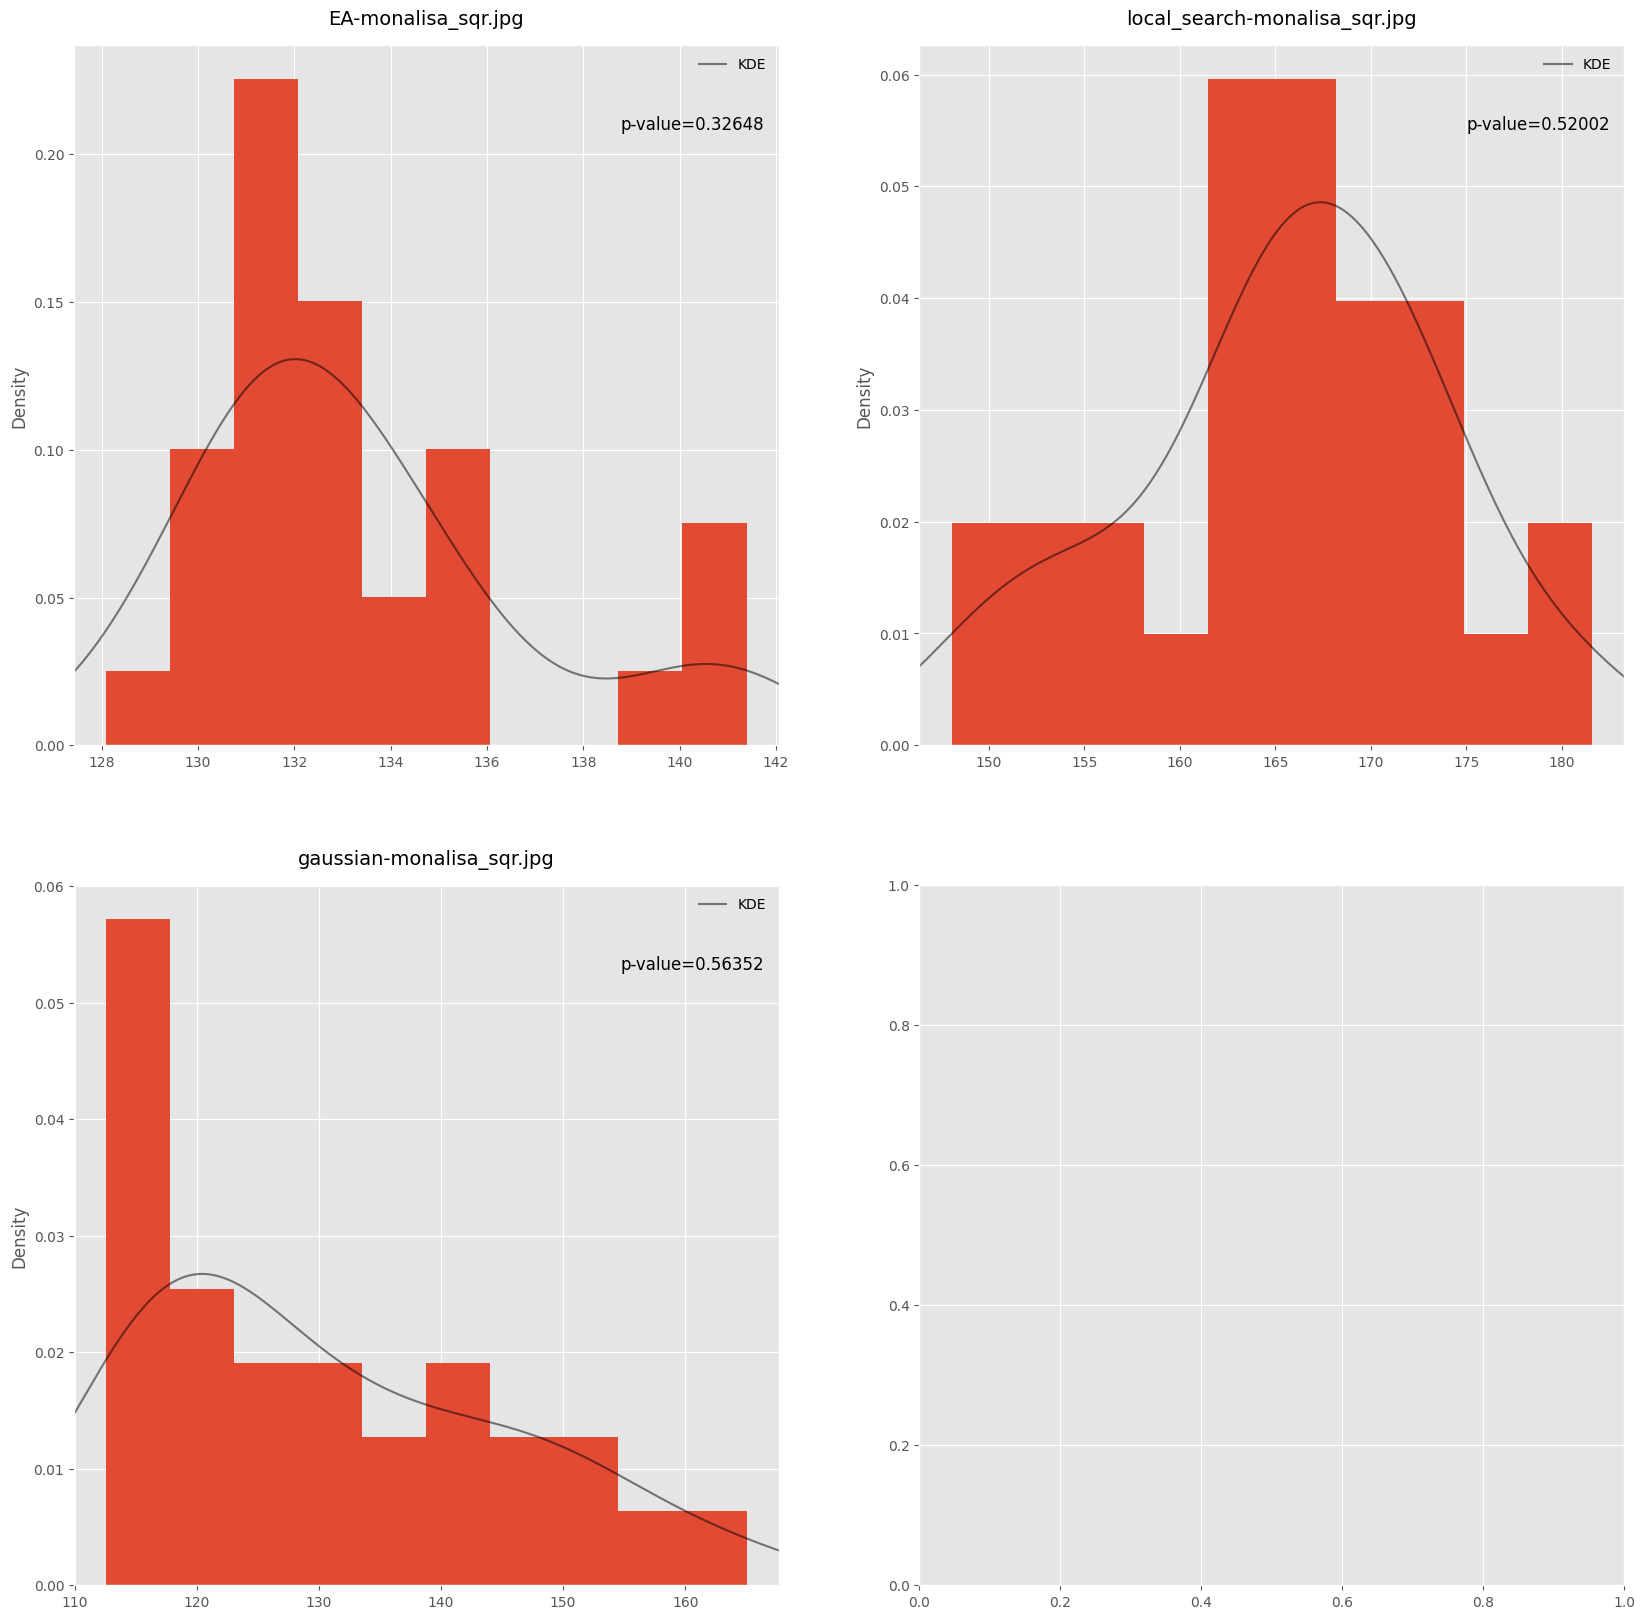

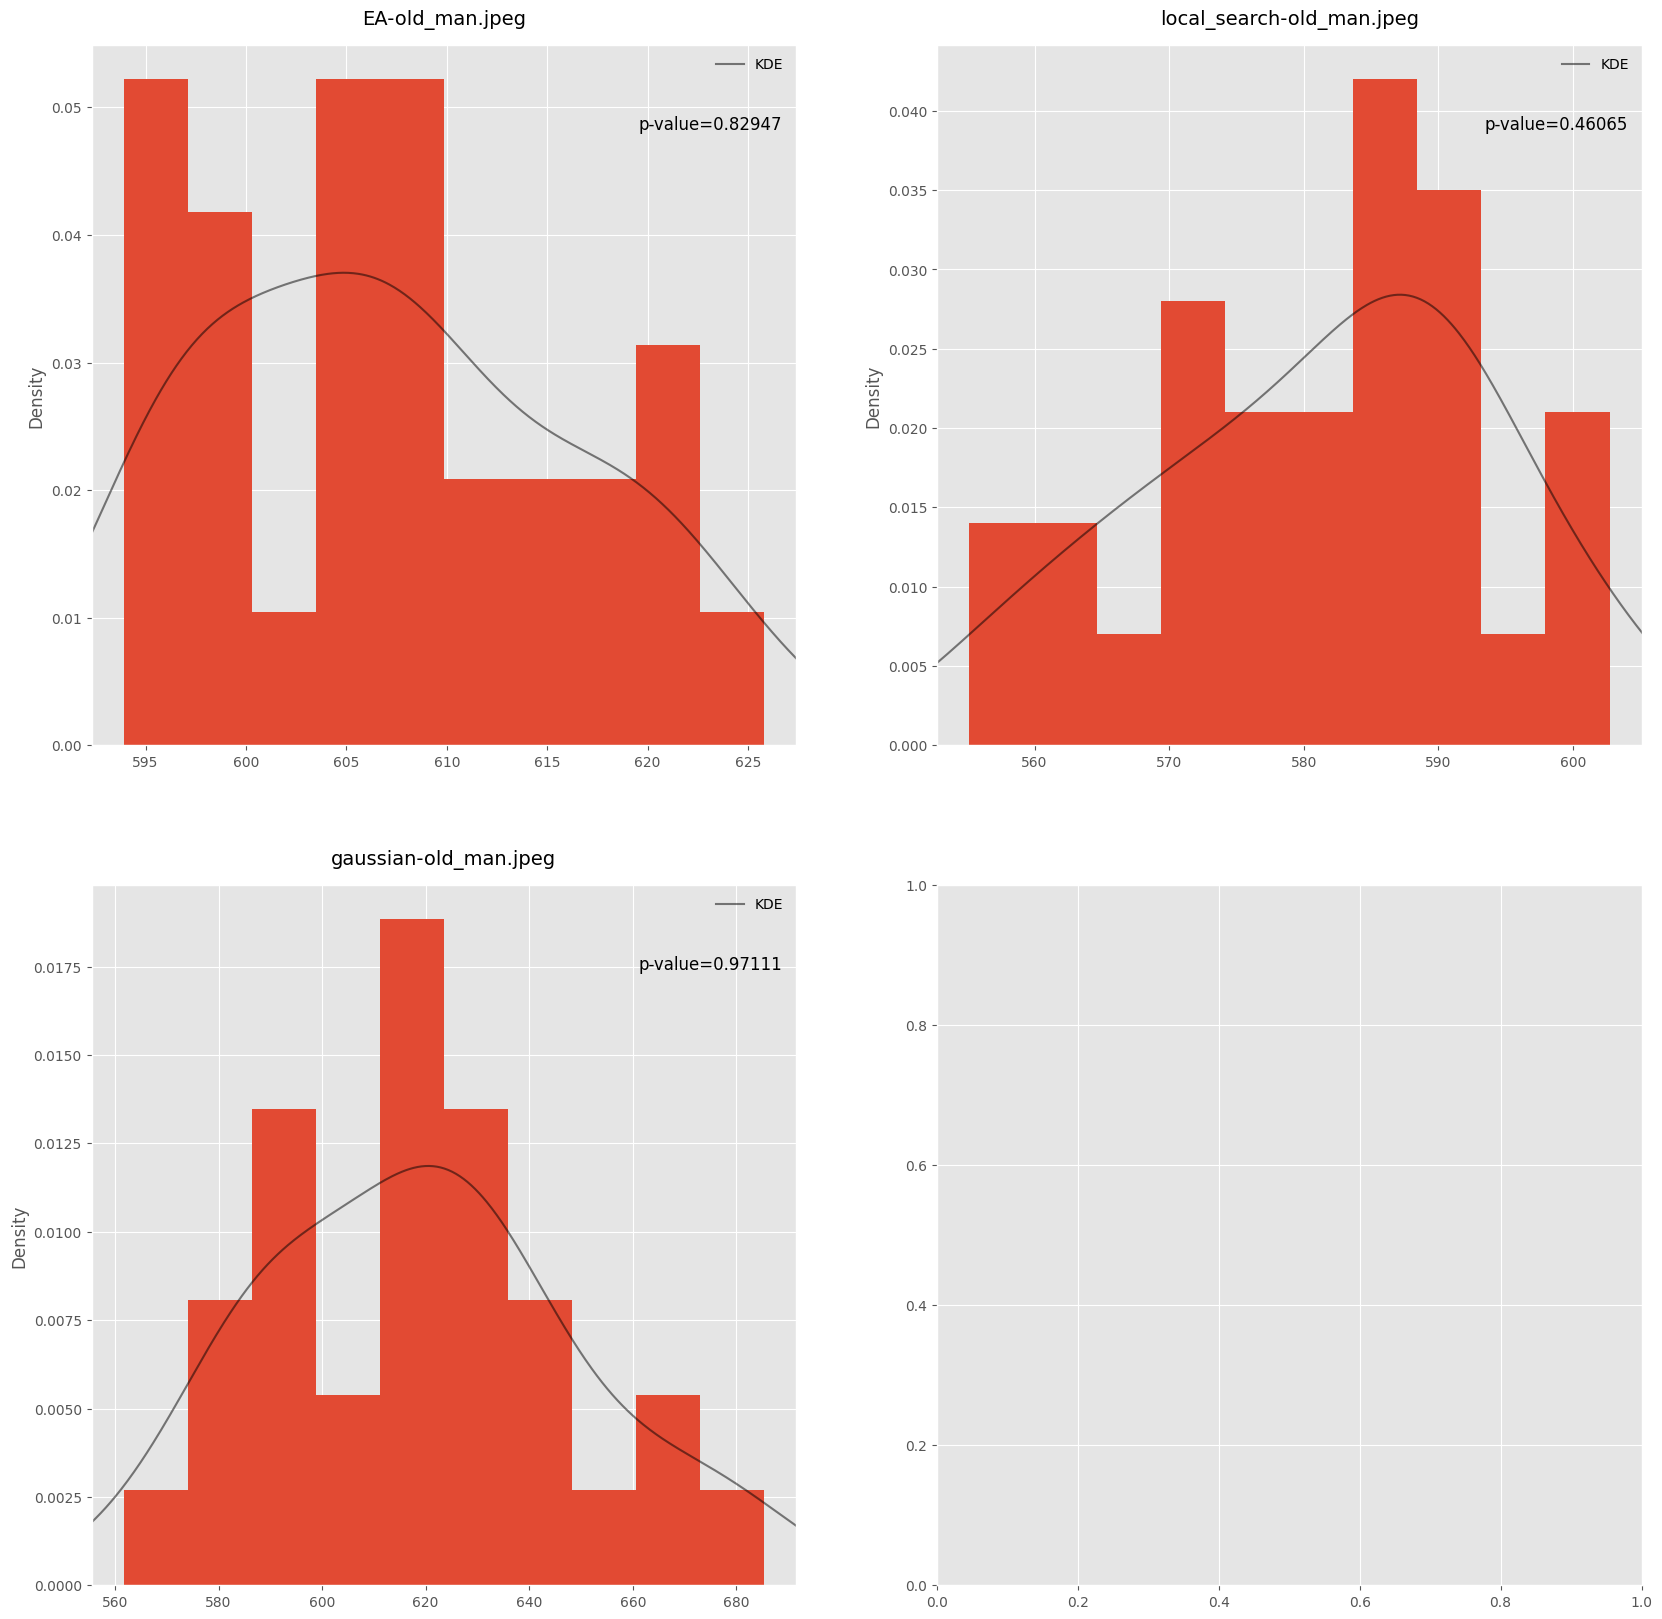

In [29]:
#Test de normalidad para cada instancia
print_hist_plots(instancia1, "comparison_instancia1")
print_hist_plots(instancia2, "comparison_instancia2")
print_hist_plots(instancia3, "comparison_instancia3")

In [30]:
#Cargar resultados de comparison
comparison_results = pd.read_csv(f"{RESULTS}comparison.csv")
comparison_results

,image,method,best_historical_fitness,avg_best_fitness,std_fitness,avg_time,p-value
0,fox.jpg,EA,194.745042,205.305028,5.396601,144.796982,0.913111
1,fox.jpg,local_search,167.122546,185.914742,11.121408,348.690822,0.460397
2,fox.jpg,gaussian,189.391407,224.928288,17.758654,359.525053,0.879996
3,monalisa_sqr.jpg,EA,128.088327,133.316016,3.370018,212.297928,0.326476
4,monalisa_sqr.jpg,local_search,148.044354,165.663568,8.011299,460.627798,0.520018
5,monalisa_sqr.jpg,gaussian,112.575717,130.533467,14.545469,470.093121,0.563523
6,old_man.jpeg,EA,593.902071,607.163763,8.868021,326.687512,0.829468
7,old_man.jpeg,local_search,555.127147,581.379431,12.603028,720.360377,0.460654
8,old_man.jpeg,gaussian,561.641796,618.912546,29.671092,710.275380,0.971106


In [31]:
#ANOVA
for instancia in [instancia1, instancia2, instancia3]:
    print(f_oneway(*[instancia[col] for col in instancia.columns]))

F_onewayResult(statistic=70.71043851586754, pvalue=5.8087196954496455e-19)
F_onewayResult(statistic=115.56375672000858, pvalue=3.20578168270887e-25)
F_onewayResult(statistic=28.687350623940322, pvalue=2.699135589260827e-10)


pvalues realmente bajos

In [32]:
#melt
best_fitnesses_comparison = [inst.melt(var_name='method-image', value_name='best_fitness') for inst in [instancia1, instancia2, instancia3]]
best_fitnesses_comparison

[        method-image  best_fitness
 0         EA-fox.jpg    206.205779
 1         EA-fox.jpg    204.505092
 2         EA-fox.jpg    202.432027
 3         EA-fox.jpg    207.050988
 4         EA-fox.jpg    199.235377
 ..               ...           ...
 85  gaussian-fox.jpg    211.207940
 86  gaussian-fox.jpg    220.035662
 87  gaussian-fox.jpg    247.241055
 88  gaussian-fox.jpg    189.391407
 89  gaussian-fox.jpg    221.855611
 
 [90 rows x 2 columns],
                  method-image  best_fitness
 0         EA-monalisa_sqr.jpg    128.088327
 1         EA-monalisa_sqr.jpg    141.387280
 2         EA-monalisa_sqr.jpg    129.635065
 3         EA-monalisa_sqr.jpg    135.253307
 4         EA-monalisa_sqr.jpg    131.043559
 ..                        ...           ...
 85  gaussian-monalisa_sqr.jpg    124.293611
 86  gaussian-monalisa_sqr.jpg    132.277649
 87  gaussian-monalisa_sqr.jpg    141.394677
 88  gaussian-monalisa_sqr.jpg    117.774432
 89  gaussian-monalisa_sqr.jpg    114.032997
 


In [33]:
#student t test

for best_fitness in best_fitnesses_comparison:
    posthoc = ph.posthoc_ttest(best_fitness, val_col='best_fitness', group_col='method-image', p_adjust='holm')
    print(posthoc)


                        EA-fox.jpg  local_search-fox.jpg  gaussian-fox.jpg
EA-fox.jpg            1.000000e+00          2.191145e-11      4.337723e-07
local_search-fox.jpg  2.191145e-11          1.000000e+00      8.437700e-14
gaussian-fox.jpg      4.337723e-07          8.437700e-14      1.000000e+00
                               EA-monalisa_sqr.jpg  \
EA-monalisa_sqr.jpg                   1.000000e+00   
local_search-monalisa_sqr.jpg         2.825009e-27   
gaussian-monalisa_sqr.jpg             3.197411e-01   

                               local_search-monalisa_sqr.jpg  \
EA-monalisa_sqr.jpg                             2.825009e-27   
local_search-monalisa_sqr.jpg                   1.000000e+00   
gaussian-monalisa_sqr.jpg                       3.975395e-16   

                               gaussian-monalisa_sqr.jpg  
EA-monalisa_sqr.jpg                         3.197411e-01  
local_search-monalisa_sqr.jpg               3.975395e-16  
gaussian-monalisa_sqr.jpg                   1.000

No hay evidencia significativa que demuestre que el método de mutación gaussiana es mejor que el EA excepto en la imagen fox.jpg. Además, la imagen old_man es significativa aunque no para alpha=0.05, podría considerarse también superior en ese caso para un alpha=0.10. Por otro lado, para monalisa no demuestra superioridad, y hasta el EA consigue mejor fitness promedio.


Este resultado es desalentador aunque cabe resaltar que el algoritmo evolutivo logra su objetivo en mucho menos tiempo promedio aún dada la cantidad de operaciones realizadas en un algoritmo evolutivo, donde es importante resaltar que dado el elitismo del AE el mejor fitness obtenido generalmente se lograba mucho antes del máximo de generaciones.

Es posible además que exista una configuración de los valores de mutación (Por ejemplo, de un gen o de un individuo) del algoritmo evolutivo para los cuales este tenga un comportamiento similar al algoritmo gaussiano, por lo cual se puede concluir que aunque logra superarlo probablemente exista una configuración que logre mejores resultados, dado que en escencia se está realizando la misma operación aunque sin otros operadores característicos de un AE.

In [34]:
csv_files = [f"{RESULTS}informal.csv", f"{RESULTS}comparison.csv", f"{RESULTS}resultados.csv"]
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]

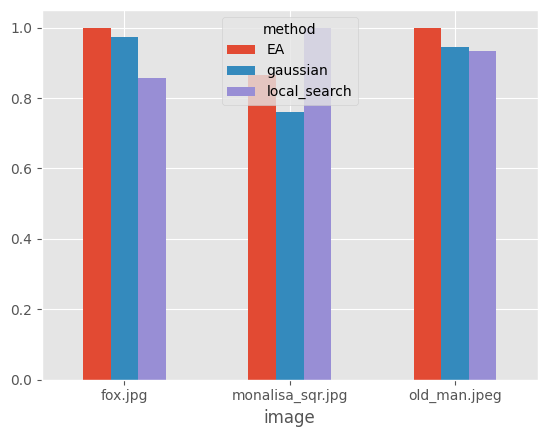

In [35]:
from Statistics import Statistics
stats = Statistics()
stats.plot_best_historical_fitness()

   CPU        time             image
0    1  394.266333           fox.jpg
1    2  222.068764           fox.jpg
2    3  169.152850           fox.jpg
3    4  145.106739           fox.jpg
4    1  557.445518  monalisa_sqr.jpg
5    2  311.957278  monalisa_sqr.jpg
6    3  233.584950  monalisa_sqr.jpg
7    4  197.812029  monalisa_sqr.jpg
8    1  783.073144      old_man.jpeg
9    2  460.797073      old_man.jpeg
10   3  348.820561      old_man.jpeg
11   4  301.556543      old_man.jpeg


f:\LABS\AE\algev_git\Statistics.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_with_images = df_with_images.append(pd.DataFrame({"CPU": row["CPU"], "time": row["time"], "image": image}))
f:\LABS\AE\algev_git\Statistics.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_with_images = df_with_images.append(pd.DataFrame({"CPU": row["CPU"], "time": row["time"], "image": image}))
f:\LABS\AE\algev_git\Statistics.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_with_images = df_with_images.append(pd.DataFrame({"CPU": row["CPU"], "time": row["time"], "image": image}))
f:\LABS\AE\algev_git\Statistics.py:230: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed ob

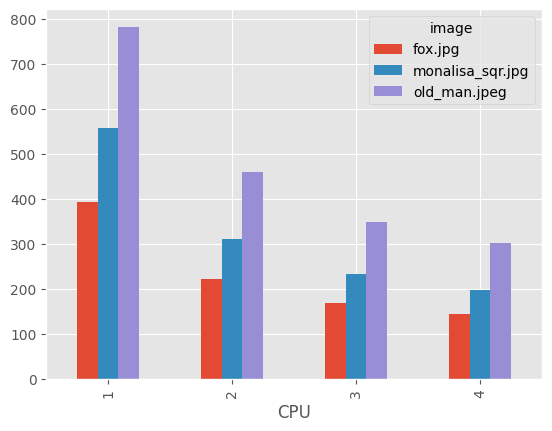

In [36]:

stats.plot_time()